# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №2: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 24 марта 18:00 Сдача **очная** на занятии. <br\>


Используйте данный Ipython Notebook при оформлении домашнего задания.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw2.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст, если явно не указана такая возможность. В противном случае -1 балл
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

Здравствуйте, уважаемые студенты! 

В этом задании мы будем реализовать линейные модели. Необходимо реализовать линейную и логистическую регрессии с L2 регуляризацией

# Теоретическое введение



Линейная регрессия решает задачу регрессии и оптимизирует функцию потерь MSE 

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right], $$ где $y_i$ $-$ целевая функция,  $a_i = a(x_i) =  \langle\,x_i,w\rangle ,$ $-$ предсказание алгоритма на объекте $x_i$, $w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Не забываем, что здесь и далее  мы считаем, что в $x_i$ есть тождественный вектор единиц, ему соответствует вес $w_0$.


Логистическая регрессия является линейным классификатором, который оптимизирует так называемый функционал log loss:

$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right],$$
где  $y_i  \in \{0,1\}$ $-$ метка класса, $a_i$ $-$ предсказание алгоритма на объекте $x_i$. Модель пытается предсказать апостериорую вероятность объекта принадлежать к классу "1":
$$ p(y_i = 1 | x_i) = a(x_i) =  \sigma( \langle\,x_i,w\rangle ),$$
$w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Функция $\sigma(x)$ $-$ нелинейная функция, пероводящее скалярное произведение объекта на веса в число $\in (0,1)$ (мы же моделируем вероятность все-таки!)

$$\sigma(x) = \frac{1}{1 + \exp(-x)}$$

Если внимательно посмотреть на функцию потерь, то можно заметить, что в зависимости от правильного ответа алгоритм штрафуется или функцией $-\log a_i$, или функцией $-\log (1 - a_i)$.



Часто для решения проблем, которые так или иначе связаны с проблемой переобучения, в функционал качества добавляют слагаемое, которое называют ***регуляризацией***. Итоговый функционал для линейной регрессии тогда принимает вид:

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right] + \frac{1}{C}R(w) $$

Для логистической: 
$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right] +  \frac{1}{C}R(w)$$

Самое понятие регуляризации введено основателем ВМК академиком Тихоновым https://ru.wikipedia.org/wiki/Метод_регуляризации_Тихонова

Идейно методика регуляризации заключается в следующем $-$ мы рассматриваем некорректно поставленную задачу (что это такое можно найти в интернете), для того чтобы сузить набор различных вариантов (лучшие из которых будут являться переобучением ) мы вводим дополнительные ограничения на множество искомых решений. На лекции Вы уже рассмотрели два варианта регуляризации.

$L1$ регуляризация:
$$R(w) = \sum_{j=1}^{D}|w_j|$$
$L2$ регуляризация:
$$R(w) =  \sum_{j=1}^{D}w_j^2$$

С их помощью мы ограничиваем модель в  возможности выбора каких угодно весов минимизирующих наш лосс, модель уже не сможет подстроиться под данные как ей угодно. 

Вам нужно добавить соотвествущую Вашему варианту $L2$ регуляризацию.

И так, мы поняли, какую функцию ошибки будем минимизировать, разобрались, как получить предсказания по объекту и обученным весам. Осталось разобраться, как получить оптимальные веса. Для этого нужно выбрать какой-то метод оптимизации.



Градиентный спуск является самым популярным алгоритмом обучения линейных моделей. В этом задании Вам предложат реализовать стохастический градиентный спуск или  мини-батч градиентный спуск (мини-батч на русский язык довольно сложно перевести, многие переводят это как "пакетный", но мне не кажется этот перевод удачным). Далее нам потребуется определение **эпохи**.
Эпохой в SGD и MB-GD называется один проход по **всем** объектам в обучающей выборки.
* В SGD градиент расчитывается по одному случайному объекту. Сам алгоритм выглядит примерно так:
        1) Перемешать выборку
        2) Посчитать градиент функции потерь на одном объекте (далее один объект тоже будем называть батчем)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* В Mini Batch SGD - по подвыборке объектов. Сам алгоритм выглядит примерно так::
        1) Перемешать выборку, выбрать размер мини-батча (от 1 до размера выборки)
        2) Почитать градиент функции потерь по мини-батчу (не забыть поделить на  число объектов в мини-батче)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* Для отладки алгоритма реализуйте возможность  вывода средней ошибки на обучении модели по объектам (мини-батчам). После шага градиентного спуска посчитайте значение ошибки на объекте (или мини-батче), а затем усредните, например, по ста шагам. Если обучение проходит корректно, то мы должны увидеть, что каждые 100 шагов функция потерь уменьшается. 
* Правило останова - максимальное количество эпох
    


# Теоретические вопросы (2 балла)
В этой части Вам будут предложены теоретичские вопросы и задачи по теме. Вы, конечно, можете списать их у своего товарища или найти решение в интернете, но учтите, что они обязательно войдут в теоретический коллоквиум. Лучше разобраться в теме сейчас и успешно ответить на коллоквиуме, чем списать, не разобравшись в материале, и быть терзаемым совестью. 


Формулы надо оформлять в формате **LaTeX**.

Задача 1. Градиент для линейной регрессии.
* Выпишите формулу обновления весов для линейной регрессии с L2 регуляризацией для мини-батч градиентого спуска размера $n$:

$$ w_{new} = w_{old} - ... $$

 Отнеситесь к этому пункту максимально серьезно, это Вам нужно будет реализовать в задании.
 
Проанализруйте итоговую формулу градиента - как  интуитивно можно  описать, чему равен градиент?

\begin{equation}
L_{*}=\frac{1}{n}\left[\sum_{i=1}^n (y_{j_{i}}-a_{j_{i}})^2\right]+\frac{1}{C} R.  \end{equation}

$$ \frac{\partial L_{*}}{\partial w}=-\frac{2}{n}\left[\sum_{i=1}^n (y_{j_{i}}-a_{j_{i}})x_{j_{i}}\right]+\frac{2}{C} w_{old}. $$

$$ w_{new} = w_{old} + \frac{2}{n}\left[\sum_{i=1}^n (y_{j_{i}}-a_{j_{i}})x_{j_{i}}\right]-\frac{2}{C} w_{old}. $$

Задача 2. Градиент для логистической регрессии.
* Выпишите формулу обновления весов для логистической регрессии с L2 регуляризацией  для мини-батч градиентого спуска размера $n$:

$$ w_{new} = w_{old} - ... $$

 Отнеситесь к этому пункту максимально серьезно, это Вам нужно будет реализовать в задании.
 
Проанализруйте итоговую формулу градиента - как  интуитивно можно  описать, чему равен градиент? Как соотносится этот градиент с градиентом, возникающий в задаче линейной регрессии?

Подсказка: Вам градиент, которой получается если “в лоб” продифференцировать,  надо немного преобразовать.
Надо подставить, что $1 - \sigma(w,x) $ это  $1 - a(x_i)$, а  $-\sigma(w,x)$ это $0 - a(x_i)$.  Тогда получится свести к одной красивой формуле с линейной регрессией, которую программировать будет намного проще.

$$L_{*} = - \frac{1}{n}\left[\sum_{i=1}^n y_{j_{i}} \log a_{j_{i}} + ( 1 - y_{j_{i}}) \log (1 - a_{j_{i}}) \right] +  \frac{1}{C}R$$

$$\frac{\partial L_{*}}{\partial w}=\frac{1}{n}\left[\sum_{i=1}^n\frac{\partial a_{j_{i}}}{\partial w}*(-\frac{y_{j_{i}}}{a_{j_{i}}}+\frac{1-y_{j_{i}}}{1-a_{j_{i}}}) \right]$$

$$ a_i = a(x_i) =  \sigma( \langle\,x_i,w\rangle ) $$

$$\sigma(x) = \frac{1}{1 + \exp(-x)}$$

$$ \frac{\partial L_{*}}{\partial w}=-\frac{2}{n}\left[\sum_{i=1}^n (y_{j_{i}}-a_{j_{i}})x_{j_{i}}\right]+\frac{2}{C} w_{old}. $$

$$ w_{new} = w_{old} + \frac{2}{n}\left[\sum_{i=1}^n (y_{j_{i}}-a_{j_{i}})x_{j_{i}}\right]-\frac{2}{C} w_{old}. $$

Задача 3. Точное решение линейной регрессии

На лекции было показано, что точное решение линейной регрессии имеет вид $w = (X^TX)^{-1}X^TY $. 
* Покажите, что это действительно является точкой минимума в случае, если матрица X имеет строк не меньше, чем столбцов и имеет полный ранг. Подсказка: посчитайте Гессиан и покажите, что в этом случае он положительно определен. 
* Выпишите точное решение для модели с $L2$ регуляризацией. Как L2 регуляризация помогает с точным решением где матрица X имеет линейно зависимые признаки?

***Ваше решение здесь***

Задача 4.  Предсказываем вероятности.

Когда говорят о логистической регрессии, произносят фразу, что она "предсказывает вероятности положительного класса". Давайте разберемся, что же за этим стоит. Посчитаем математическое ожидание функции потерь и проверим, что предсказание алгоритма, оптимизирующее это мат. ожидание, будет являться вероятностью положительного класса. 

И так, функция потерь на объекте $x_i$, который имеет метку $y_i \in \{0,1\}$  для предсказания $a(x_i)$ равна:
$$L(y_i, b) =-[y_i == 1] \log a(x_i)  - [y_i == 0] \log(1 - a(x_i)) $$

Где $[]$ означает индикатор $-$ он равен единице, если значение внутри него истинно, иначе он равен нулю. Тогда мат. ожидание при условии конкретного $x_i$  по определение мат. ожидания дискретной случайной величины:
$$E(L | x_i) = -p(y_i = 1 |x_i ) \log a(x_i)  - p(y_i = 0 | x_i) \log( 1 - a(x_i))$$
* Докажите, что значение $a(x_i)$, минимизирующее данное мат. ожидание, в точности равно $p(y_i = 1 |x_i)$, то есть равно вероятности положительного класса.

Подсказка: возможно, придется воспользоваться, что  $p(y_i = 1 | x_i) + p(y_i = 0 | x_i) = 1$

$$ \frac{\partial E}{\partial a_i}=-\frac{p_1}{a_i}+\frac{p_0}{1-a_i}=\frac{p_0*a_i-p_1*(1-a_i)}{a_i*(1-a_i)} $$

$$ \frac{\partial E}{\partial a_i}=0 $$

$$ 0=p_0*a_i-p_1*(1-a_i)=a_i*(p_1+p_0)-p_1=a_i-p_1 $$

Задача 5.  Смысл регуляризации.

Нужно ли в L1/L2 регуляризации использовать свободный член $w_0$ (который не умножается ни на какой признак)?

Подсказка: подумайте, для чего мы вводим $w_0$

***Ваше решение здесь***

#  Реализация линейной модели (4 балла)

## Зачем нужны батчи?


Как Вы могли заметить из теоретического введения, что в случае SGD, что в случа mini-batch GD,  на каждой итерации обновление весов  происходит только по небольшой части данных (1 пример в случае SGD, batch примеров в случае mini-batch). То есть для каждой итерации нам *** не нужна вся выборка***. Мы можем просто итерироваться по выборке, беря батч нужного размера (далее 1 объект тоже будем называть батчом).

Легко заметить, что в этом случае нам не нужно загружать все данные в оперативную память, достаточно просто считать батч с диска, обновить веса, считать диска другой батч и так далее. В целях упрощения домашней работы, прямо с диска  мы считывать не будем, будем работать с обычными numpy array. 





## Немножко про генераторы в Python



Идея считывания данных кусками удачно ложится на так называемые ***генераторы*** из языка Python. В данной работе Вам предлагается не только разобраться с логистической регрессией, но  и познакомиться с таким важным элементом языка.  При желании Вы можете убрать весь код, связанный с генераторами, и реализовать логистическую регрессию и без них, ***штрафоваться это никак не будет***. Главное, чтобы сама модель была реализована правильно, и все пункты были выполнены. 

Подробнее можно почитать вот тут https://anandology.com/python-practice-book/iterators.html


К генератору стоит относиться просто как к функции, которая порождает не один объект, а целую последовательность объектов. Новое значение из последовательности генерируется с помощью ключевого слова ***yield***. Ниже Вы можете насладиться  генератором чисел Фибоначчи.

In [2]:
def fib(max_iter=4):
    a, b = 0, 1
    iter_num = 0
    while 1:
        yield a
        a, b = b, a + b
        iter_num += 1
        if iter_num == max_iter:
            break

Вот так можно сгенерировать последовательность Фибоначчи. 

Заметьте, что к генераторам можно применять некоторые стандартные функции из Python, например enumerate.

In [3]:
new_generator = fib()
for j, fib_val in enumerate(new_generator):
    print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


Пересоздавая объект, можно сколько угодно раз генерировать заново последовательность. 

In [4]:
for i in range(0, 3):
    new_generator = fib()
    for j, fib_val in enumerate(new_generator):
        print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2
Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2
Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


А вот так уже нельзя.

In [5]:
new_generator = fib()
for i in range(0, 3):
    for j, fib_val in enumerate(new_generator):
        print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


Концепция крайне удобная для обучения  моделей $-$ у Вас есть некий источник данных, который Вам выдает их кусками, и Вам совершенно все равно откуда он их берет. Под ним может скрывать как массив в оперативной памяти, как файл на жестком диске, так и SQL база данных. Вы сами данные никуда не сохраняете, оперативную память экономите.

Если Вам понравилась идея с генераторами, то Вы можете реализовать свой, используя прототип batch_generator. В нем Вам нужно выдавать батчи признаков и ответов для каждой новой итерации спуска. Если не понравилась идея, то можете реализовывать SGD или mini-batch GD без генераторов.

In [14]:
import random

def batch_generator(X, y, shuffle=True, batch_size=1000):
    """
    Гератор новых батчей для обучения
    X          - матрица объекты-признаки
    y_batch    - вектор ответов
    shuffle    - нужно ли случайно перемешивать выборку
    batch_size - размер батча ( 1 это SGD, > 1 mini-batch GD)
    Генерирует подвыборку для итерации спуска (X_batch, y_batch)
    """
    #X=(X-np.expand_dims(X.min(axis=0),axis=0))/(np.expand_dims(X.max(axis=0),axis=0)-np.expand_dims(X.min(axis=0),axis=0))
    Xn=np.hstack((X,np.expand_dims(y,axis=1)))#np.hstack((np.expand_dims(np.ones(X.shape[0]),axis=1),np.hstack((X,np.expand_dims(y,axis=1)))))
    if (shuffle):
        np.random.shuffle(Xn)
    for i in range(Xn.shape[1]):
        num=np.asarray(range(Xn.shape[0]))
        np.random.shuffle(num)
        M=Xn[num]
        X_batch = M[:batch_size,:-1]
        y_batch = M[:batch_size,-1]#np.expand_dims(np.asarray(M[1,-1]),axis=0)
        #print(X_batch.shape,y_batch.shape)
        yield (X_batch, y_batch)

# Теперь можно сделать генератор по данным ()
#  my_batch_generator = batch_generator(X, y, shuffle=True, batch_size=1):

In [91]:
#%%pycodestyle

def sigmoid(x):
    """
    Вычисляем значение сигмоида.
    X - выход линейной модели
    """
    
    sigm_value_x = 1/(1+np.e**(-x))  
    return sigm_value_x


from sklearn.base import BaseEstimator, ClassifierMixin

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, batch_generator, C=1, alpha=0.01, max_epoch=10, model_type='lin_reg'):
        """
        batch_generator -- функция генератор, которой будем создавать батчи
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        model_type - тим модели, lin_reg или log_reg
        """
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.batch_generator = batch_generator
        self.errors_log = {'iter' : [], 'loss' : []}  
        self.model_type = model_type
        
    def calc_loss(self, X_batch, y_batch):
        """
        Считаем функцию потерь по батчу 
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """
        lossar=(np.expand_dims(self.weights,axis=0)*X_batch).sum(axis=0)
        #print (lossar.shape)
        if (self.model_type=='lin_reg'):
            loss=((y_batch-lossar)**2).sum()/lossar.shape[0]+(self.weights**2).sum()/self.C
        else:
            lossar=sigmoid(lossar)
            loss=-(y_batch*np.log(lossar).sum()+(1-y_batch)*np.log(-(lossar-np.ones(lossar.shape))).sum())/lossar.shape[0]+(self.weights**2).sum()/self.C
        return loss
    
    def calc_loss_grad(self, X_batch, y_batch):
        """
        Считаем  градиент функции потерь по батчу (то что Вы вывели в задании 1)
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """
        lossar=(np.expand_dims(self.weights,axis=0)*X_batch).sum(axis=1)
        #print(lossar.shape)
        if (self.model_type!='lin_reg'):
                   lossar=sigmoid(lossar)
        loss_grad=-2/lossar.shape[0]*(np.expand_dims(y_batch-lossar,axis=1)*X_batch).sum(axis=0)+self.weights*2/self.C
        return loss_grad
    
    def update_weights(self, new_grad):
        """
        Обновляем вектор весов
        new_grad - градиент по батчу
        """
        self.weights=self.weights-new_grad*np.expand_dims(np.asarray(self.alpha),axis=0)
    
    def fit(self, X, y):
        '''
        Обучение модели
        X - матрица объекты-признаки
        y - вектор ответов
        '''
        
        # Нужно инициализровать случайно веса
        self.weights = np.random.rand(X.shape[1])
        #self.mini=np.expand_dims(X.min(axis=0),axis=0)
        #self.maxi=np.expand_dims(X.max(axis=0),axis=0)
        for n in range(0, self.max_epoch):
            new_epoch_generator = self.batch_generator(X,y)
            for batch_num, new_batch in enumerate(new_epoch_generator):
                X_batch = new_batch[0]
                y_batch = new_batch[1]
                batch_grad = self.calc_loss_grad(X_batch, y_batch)
                self.update_weights(batch_grad)
                # Подумайте в каком месте стоит посчитать ошибку для отладки модели
                # До градиентного шага или после
                batch_loss = self.calc_loss(X_batch, y_batch)
                self.errors_log['iter'].append(batch_num)
                self.errors_log['loss'].append(batch_loss)
                
        return self
        
    def predict(self, X):
        '''
        Предсказание класса
        X - матрица объекты-признаки
        Не забудте тип модели (линейная или логистическая регрессия)!
        '''
        #X=(X-self.mini)/(self.maxi-self.mini)
        predar=(np.expand_dims(self.weights,axis=0)*X).sum(axis=1)#*np.hstack((np.expand_dims(np.ones(X.shape[0]),axis=1),X))).sum(axis=1)
        if (self.model_type=='lin_reg'):
                y_hat=predar
        else:
                y_hat=np.multiply(((sigmoid(predar)-0.5)>0),1)
        # Желательно здесь использовать матричные операции между X и весами, например, numpy.dot 
        return y_hat

Запустите обе регрессии на синтетических данных. 


Выведите полученные веса и нарисуйте разделяющую границу между классами (используйте только первых два веса для первых двух признаков X[:,0], X[:,1] для отображения в 2d пространство ).  

In [64]:
def plot_decision_boundary(clf):
    w=clf.weights
    print(w.shape)
    plt.plot(np.asarray([-(w[1]*(-5))/w[0],-(w[1]*(3))/w[0]]),np.asarray([-5,3]))
    #plt.show()

(2,)


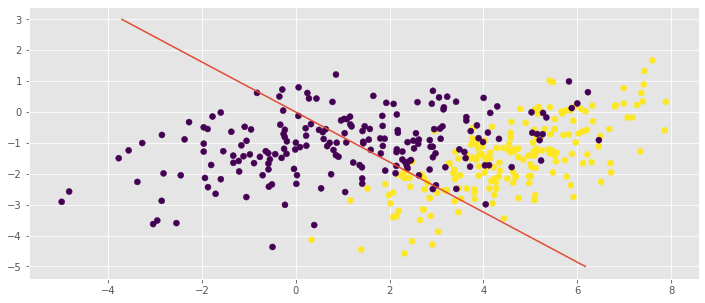

In [65]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

your_model=MySGDClassifier(batch_generator,model_type='log_reg')
your_model.fit(X,y)

plot_decision_boundary(your_model)
plt.scatter(X[:,0], X[:,1], c=y)

Далее будем анализировать Ваш алгоритм. 
Для этих заданий используйте датасет ниже.

In [92]:
from sklearn.datasets import make_classification

In [93]:
X, y = make_classification(n_samples=100000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

In [94]:
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
begi=KFold(n_splits=3)
for train, test in begi.split(X):
    train=np.asarray(train)
    test=np.asarray(test)
    classer=MySGDClassifier(batch_generator,model_type='log_reg')
    classer.fit(X[train],y[train])
    lol=classer.predict(X[test])
    #print(y[test].shape, lol.shape)
    #print(lol)
    print(f1_score(y[test], lol))

0.9523986612123466
0.9460445227015469
0.9491259454539748


Покажите сходимости обеих регрессией на этом датасете: изобразите график  функции потерь, усредненной по $N$ шагам градиентого спуска, для разных `alpha` (размеров шага). Разные `alpha` расположите на одном графике. 

$N$ можно брать 10, 50, 100 и т.д. 

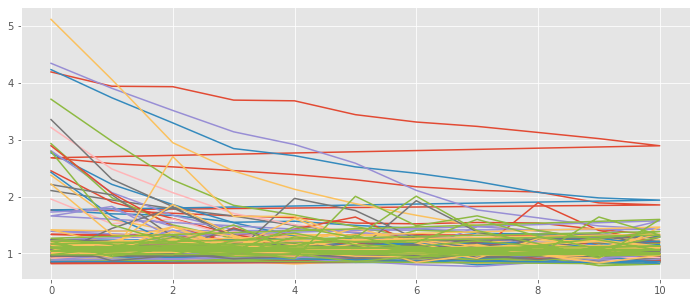

In [21]:
alpha=[0.01*i for i in range(1,21)]
for a in alpha:
        classer=MySGDClassifier(batch_generator,alpha=a,model_type='log_reg')
        classer.fit(X,y)
        plt.plot(classer.errors_log['iter'],classer.errors_log['loss'])
plt.show()

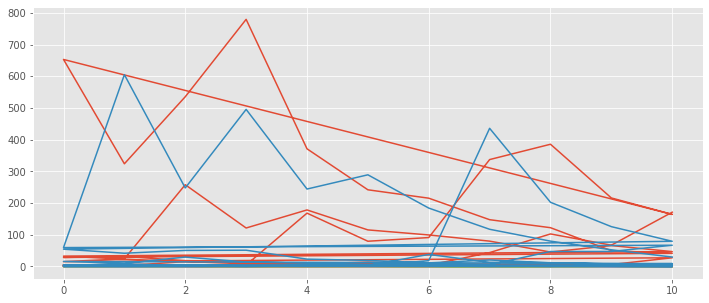

In [22]:
alpha=[0.01*i for i in range(1,10)]
for a in alpha:
        classer=MySGDClassifier(batch_generator,alpha=a)
        classer.fit(X,y)
        plt.plot(classer.errors_log['iter'],classer.errors_log['loss'])
plt.show()

Что Вы можете сказать про сходимость метода при различных `alpha`? Какое значение стоит выбирать для лучшей сходимости?

Изобразите график среднего значения весов для обеих регрессий в зависимости от коеф. регуляризации С из `np.logspace(3, -3, 10)` 

[1.00000000e+03 2.15443469e+02 4.64158883e+01 1.00000000e+01
 2.15443469e+00 4.64158883e-01 1.00000000e-01 2.15443469e-02
 4.64158883e-03 1.00000000e-03]


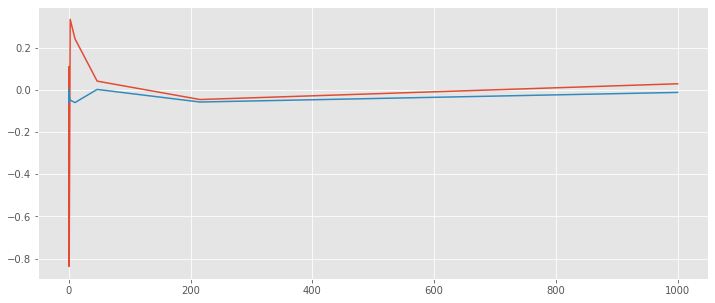

In [25]:
con=np.logspace(3, -3, 10)
w=[]
print(con)
for c in con:
    classer=MySGDClassifier(batch_generator,alpha=a)
    classer.fit(X,y)
    w.append(classer.weights.mean())
plt.plot(con,w)
w=[]
for c in con:
    classer=MySGDClassifier(batch_generator,alpha=a,model_type='log_reg')
    classer.fit(X,y)
    w.append(classer.weights.mean())
plt.plot(con,w)

Довольны ли Вы, насколько сильно уменьшились Ваши веса? 

# Боевое применение (4  балла)

**Защита данной части возможна только при преодолении в проекте бейзлайна Handmade baseline.**

Давайте применим модель на итоговом проекте! Датасет сделаем точно таким же образом, как было показано в project_overview.ipynb

Применим обе регрессии, подберем для них параметры и сравним качество. Может быть Вы еще одновременно с решением домашней работы подрастете на лидерборде!

In [118]:
doc_to_title = {}
with open('docs_titles.tsv') as f:
    for num_line, line in enumerate(f):
        if num_line == 0:
            continue
        data = line.strip().split('\t', 1)
        doc_id = int(data[0])
        if len(data) == 1:
            title = ''
        else:
            title = data[1]
        doc_to_title[doc_id] = title
print (len(doc_to_title))


28026


In [119]:
import pandas as pd
train_data = pd.read_csv('train_groups.csv')
traingroups_titledata = {}
for i in range(len(train_data)):
    new_doc = train_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    target = new_doc['target']
    title = doc_to_title[doc_id]
    if doc_group not in traingroups_titledata:
        traingroups_titledata[doc_group] = []
    traingroups_titledata[doc_group].append((doc_id, title, target))

In [120]:
import numpy as np
y_train = []
X_train = []
groups_train = []
for new_group in traingroups_titledata:
    docs = traingroups_titledata[new_group]
    for k, (doc_id, title, target_id) in enumerate(docs):
        y_train.append(target_id)
        groups_train.append(new_group)
        all_dist = []
        words = set(title.strip().split())
        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_id_j, title_j, target_j = docs[j]
            words_j = set(title_j.strip().split())
            all_dist.append(len(words.intersection(words_j)))
        X_train.append(sorted(all_dist, reverse=True)[0:15]    )
X_train = np.array(X_train)
y_train = np.array(y_train)
groups_train = np.array(groups_train)
print (X_train.shape, y_train.shape, groups_train.shape)

(11690, 15) (11690,) (11690,)


Подберите размер батча для обучения. Линейная модель не должна учиться дольше нескольких минут. 

Не забывайте использовать скейлер!

In [111]:
from sklearn.metrics import f1_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

Разбейте данные на обучение и валидацию. Подберите параметры C, alpha, max_epoch, model_type на валидации (Вы же помните, как правильно в этой задаче делать валидацию?)

In [112]:
scaler=StandardScaler()
scaler.fit(X_train)
X_train=scaler.transform(X_train)

In [33]:
from sklearn.model_selection import KFold, cross_validate, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

begi=KFold(n_splits=5)
res=[]
alpha=[0.005*i for i in range(1,21)]
con=np.logspace(3, -3, 10)
mah=[10,50,100,200,500,1000]
for i in range(20):
    res.append([])
    for c in con:
        s=0
        for train, test in begi.split(X_train):
            train=np.asarray(train)
            test=np.asarray(test)
            classer=MySGDClassifier(batch_generator,alpha=0.005*(i+1),C=c,model_type='log_reg')
            classer.fit(X_train[train],y_train[train])
            lol=classer.predict(X_train[test])
            #print(y[test].shape, lol.shape)
            #print(lol)
            #print(f1_score(y[test], lol),classer.weights)
            s+=f1_score(y_train[test], lol)
        s/=5
        print(s)
        #print(res,i,j)
        res[i].append(s)

0.6066006851574705
0.6060609976174667
0.6055277395454036
0.6098687568691827
0.6098284946227575
0.6108577042028214
0.6090929103831504
0.5193889206976785


/Users/treatpetr/opt/anaconda3/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log
/Users/treatpetr/opt/anaconda3/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in multiply
/Users/treatpetr/opt/anaconda3/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in power
  if __name__ == '__main__':


0.6083907102743641


/Users/treatpetr/opt/anaconda3/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: overflow encountered in double_scalars


0.6063654135222392
0.611991864200931
0.6069923148717017
0.6091025572481019
0.6036751807002858
0.6108035974328192
0.6091859779611914
0.4225308988464708
0.5292651782388196
0.6098470219067837


/Users/treatpetr/opt/anaconda3/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: overflow encountered in square


0.6100819370827448
0.602122485671041
0.6010856891653776
0.6004290268847718
0.5367008699079227
0.6098195597394851
0.5356669213547453
0.45458909727709373
0.4956311850743858
0.6084741019629496
0.6073603988785247
0.6107587937738483
0.6016785173433302
0.6066924786186902
0.5979037283301573
0.60546733277568
0.603931734004153
0.6075193859317624
0.38004956967571213
0.6084364317572625


/Users/treatpetr/opt/anaconda3/envs/sphere-py37/lib/python3.7/site-packages/numpy/core/_methods.py:38: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


0.6061125773012936
0.5818568295943619
0.6067988999717225
0.6054564698877105
0.6056719435521843
0.6095483982181683
0.5174178513359127
0.6105732550402031
0.6089918882272863
0.6040061545414485
0.6095691175396875
0.5446826776332052
0.6071063254033391
0.6019294238701715
0.6010075252639655
0.4879957290562861
0.6053845824798202
0.518109359415887
0.6080166827757694
0.6066942348736977
0.6094747129681726
0.5999610221614224
0.6068797644315033
0.6083641177510494
0.5154588786079619
0.5274813246910331
0.6109809288311373
0.4531872124678563
0.6134510461956567
0.6057839691554018
0.6084055751195176
0.5181005614660512
0.5542163128105864
0.537180244907493
0.5271465976026741
0.42531250365288686
0.5373941386806792
0.35282709084484304
0.6076831090517872
0.6083275379095285
0.6081720346461926
0.5474061996191584
0.6065093751933395
0.6058923789177624
0.6047530413199006
0.6015579778989035
0.6089706664126101
0.4400981144185354
0.6077921842193399
0.6071148136137646


/Users/treatpetr/opt/anaconda3/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: overflow encountered in true_divide
/Users/treatpetr/opt/anaconda3/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in subtract
/Users/treatpetr/opt/anaconda3/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in greater
/Users/treatpetr/opt/anaconda3/envs/sphere-py37/lib/python3.7/site-packages/numpy/core/_methods.py:38: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


0.0
0.6068938711307763
0.6028588590835444
0.5373548643583437
0.6055532824969372
0.6078972429691021
0.5741705919532664
0.5322640408361844
0.610119393681619
0.6076218205067911
0.0
0.5846538967335986
0.6046326630881675
0.5531374996685112
0.6092419431398505
0.6041085025644473
0.6157072570801991
0.5287130976288961
0.6070702041779753
0.6055743984107623
0.0
0.5957999463328181
0.5972923239622459
0.4999111391714239
0.5261045000446892
0.5544670727009274
0.6044830273665364
0.5144489265099216
0.6089637997568774
0.6057482132962011
0.0
0.6021234623767958
0.598206191111448
0.6078774304557563
0.6056757432445142
0.5289342943320604
0.5757503710017563
0.5192067644408362
0.6081297713508285
0.6094136530932235
0.0
0.5987994421423095
0.5792457108501181
0.455129763172995
0.6105697768180045
0.3865041568148976
0.6108766186658968
0.34197418854838013
0.6056083942068882
0.6070140431585915
0.0
0.5243476658810706
0.5970230754911577
0.5841396444014032
0.602006566337564
0.5914097224307076
0.45903019395341393
0.4276068

In [57]:
res=np.asarray(res)
print(np.argmax(res)//10,np.argmax(res)%10,np.max(res),res[8:13,3:8])
print(alpha[10],con)

10 5 0.6157072570801991 [[0.60475304 0.60155798 0.60897067 0.44009811 0.60779218]
 [0.60555328 0.60789724 0.57417059 0.53226404 0.61011939]
 [0.60924194 0.6041085  0.61570726 0.5287131  0.6070702 ]
 [0.5261045  0.55446707 0.60448303 0.51444893 0.6089638 ]
 [0.60567574 0.52893429 0.57575037 0.51920676 0.60812977]]
0.055 [1.00000000e+03 2.15443469e+02 4.64158883e+01 1.00000000e+01
 2.15443469e+00 4.64158883e-01 1.00000000e-01 2.15443469e-02
 4.64158883e-03 1.00000000e-03]


In [60]:
mah=[10,50,100,200,500,1000]
begi=KFold(n_splits=5)
for m in mah:
    for train, test in begi.split(X_train):
        train=np.asarray(train)
        test=np.asarray(test)
        classer=MySGDClassifier(batch_generator,alpha=alpha[10],C=con[5],max_epoch=m,model_type='log_reg')
        classer.fit(X_train[train],y_train[train])
        lol=classer.predict(X_train[test])
        #print(y[test].shape, lol.shape)
        #print(lol)
        #print(f1_score(y[test], lol),classer.weights)
        s+=f1_score(y_train[test], lol)
    s/=5
    print(s,m)

0.5828052002001057 10
0.5751145825192434 50
0.7232815090550522 100
0.7539603327656852 200
0.6786602881259156 500
0.601172588372388 1000


In [62]:
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
X, y = make_regression(n_samples=100000, n_features=10, 
                           n_informative=4, 
                           random_state=123)
scaler=StandardScaler()
scaler.fit(X)
X=scaler.transform(X)
begi=KFold(n_splits=3)
for train, test in begi.split(X):
    train=np.asarray(train)
    test=np.asarray(test)
    classer=MySGDClassifier(batch_generator,alpha=alpha[10],C=con[5],max_epoch=200)
    classer.fit(X[train],y[train])
    lol=classer.predict(X[test])
    #print(y[test].shape, lol.shape)
    #print(lol)
    print(mean_squared_error(y[test], lol))

9521.278821301661
11988.161653628322
11575.977387200892


Подберите порог линейной модели, по достижении которого, Вы будете относить объект к классу 1. Вспомните, какую метрику мы оптимизируем в соревновании.  Как тогда правильно подобрать порог?

In [114]:
begi=KFold(n_splits=3)
for train, test in begi.split(X_train):
    train=np.asarray(train)
    test=np.asarray(test)
    classer=MySGDClassifier(batch_generator,alpha=alpha[10],C=con[5],max_epoch=200,model_type='log_reg')
    classer.fit(X_train[train],y_train[train])
    lol=classer.predict(X_train[test])
    #print(y[test].shape, lol.shape)
    #print(lol)
    #print(f1_score(y[test], lol),classer.weights)
    print(f1_score(y_train[test], lol))

0.5826351865955826
0.6120218579234974
0.6488956587966488


С лучшими параметрами на валидации сделайте предсказание на тестовом множестве, отправьте его на проверку на платформу kaggle. Убедитесь, что Вы смогли побить public score первого бейзлайна.

** При сдаче домашки Вам необходимо кроме ссылки на ноутбук показать Ваш ник на kaggle, под которым Вы залили решение, которое побило Handmade baseline. **

In [61]:
scaler=StandardScaler()
scaler.fit(X_train)
X_train=scaler.transform(X_train)
classer=MySGDClassifier(batch_generator,alpha=0.1,C=0.1,model_type='log_reg')
classer.fit(X_train,y_train)

MySGDClassifier(C=0.1, alpha=0.1,
                batch_generator=<function batch_generator at 0x123683b00>,
                max_epoch=10, model_type='log_reg')

In [121]:
test_data = pd.read_csv('test_groups.csv')
test_data.head()

,pair_id,group_id,doc_id
0,11691,130,6710
1,11692,130,4030
2,11693,130,5561
3,11694,130,4055
4,11695,130,4247


In [122]:
testgroups_titledata = {}
for i in range(len(test_data)):
    new_doc = test_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    title = doc_to_title[doc_id]
    if doc_group not in testgroups_titledata:
        testgroups_titledata[doc_group] = []
    testgroups_titledata[doc_group].append((doc_id, title))

In [123]:
X_test = []
groups_test = []
for new_group in testgroups_titledata:
    docs = testgroups_titledata[new_group]
    for k, (doc_id, title) in enumerate(docs):
        groups_test.append(new_group)
        all_dist = []
        words = set(title.strip().split())
        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_id_j, title_j = docs[j]
            words_j = set(title_j.strip().split())
            all_dist.append(len(words.intersection(words_j)))
        X_test.append(sorted(all_dist, reverse=True)[0:15]    )
X_test = np.array(X_test)
groups_test = np.array(groups_test)
print (X_test.shape, groups_test.shape)

(16627, 15) (16627,)


In [124]:
lol=classer.predict(X_test)

In [125]:
from sklearn.model_selection import KFold
begi=KFold(n_splits=5)
y_new=np.zeros(X_test.shape[0])
scaler=StandardScaler()
scaler.fit(X_train)
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)
for train, test in begi.split(X_train):
    train=np.asarray(train)
    test=np.asarray(test)
    classer=MySGDClassifier(batch_generator,alpha=0.1,C=0.1,model_type='lod_reg')
    classer.fit(X_train[train],y_train[train])
    lol=classer.predict(X_test)
    y_new=y_new+(lol==1)
    #print(y[test].shape, lol.shape)
    #print(lol)
    #print(f1_score([test], lol))

/Users/treatpetr/opt/anaconda3/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log
/Users/treatpetr/opt/anaconda3/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in multiply


In [126]:
lol2=np.multiply((y_new>2),1)

In [127]:
lol2

array([0, 1, 1, ..., 1, 1, 1])

In [128]:
pair=np.asarray(test_data['pair_id'])
df=pd.DataFrame({
    'pair_id': pair,
    'target':lol2})
df.to_csv('test9.csv',index=False) 

# Фидбек (бесценно)

* Какие аспекты обучения линейных моделей Вам показались непонятными? Какое место стоит дополнительно объяснить?

***Ваше ответ здесь***

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.   

*** ВАШ ОТЗЫВ ЗДЕСЬ***